<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/SWaT_for_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# !pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2
# import pytorch_lightning as pl
# print(pl.__version__)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from multiprocessing import cpu_count
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import confusion_matrix, classification_report
import scipy.stats as stats

In [9]:
%matplotlib inline
%config InlineBackend.figure_format= 'retina'

tqdm.pandas()

In [10]:
#set random seed
pl.seed_everything(44)

Global seed set to 44


44

## data preprocessing

In [11]:
!unzip -qq SWaT_Dataset_v0.zip

In [12]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [13]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_normal.columns.str.replace(' ','')

In [14]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [15]:
swat = pd.concat([swat_normal,swat_attack],axis = 0)

le = LabelEncoder()
le.fit(swat["Normal/Attack"])

LabelEncoder()


### Process normal data
use normal data for training & tuning time window (W) and threshold (T)


In [16]:
x = swat_normal.drop(columns="Normal/Attack")[["FIT101","LIT101","MV101","P101","P102"]]
y = swat_normal.drop(np.arange(16000))["Normal/Attack"]

In [17]:
y = pd.DataFrame(
    le.transform(y), #normal 1, attack 0
    index = y.index,
    columns= ["Normal/Attack"]
)

In [18]:
# drop unsteady state operation
x.drop(np.arange(16000),inplace=True)

In [19]:
#normalise data
scaler = StandardScaler()
scaler = scaler.fit(x)

In [20]:
x_scale = pd.DataFrame(
    scaler.transform(x),
    index = x.index,
    columns= x.columns
)

In [21]:
#convert to sequence
def sequences_convert(input_data: pd.DataFrame,actual: pd.DataFrame, sequence_length):
    seqs = []
    data_size = len(input_data)
    
    for i in tqdm(range(0,data_size-sequence_length*2)):
        
        seq = input_data[i:i+sequence_length]

        label = input_data.iloc[i+sequence_length:i+sequence_length*2]

        attack = actual.iloc[i+sequence_length:i+sequence_length*2]

        
        seqs.append((seq,label,attack))
    
    return seqs



In [22]:
# import time
sequence_length = 200
x_seq = sequences_convert(x_scale,y,sequence_length)

  0%|          | 0/480400 [00:00<?, ?it/s]

In [23]:
len(x_seq), x.shape

(480400, (480800, 5))

In [24]:
#split train/test use 80% train, 20% test (validation)
train_idx = int(len(x_seq)*0.8)
train_seq = x_seq[:train_idx]
test_seq = x_seq[train_idx:-1]


In [25]:
len(train_seq), len(test_seq)

(384320, 96079)

In [26]:
test_seq[-1]

(          FIT101    LIT101     MV101     P101  P102
 496398  0.558344 -0.677598  0.619776  0.58386   0.0
 496399  0.547949 -0.681018  0.619776  0.58386   0.0
 496400  0.530530 -0.677598  0.619776  0.58386   0.0
 496401  0.524630 -0.675888  0.619776  0.58386   0.0
 496402  0.520136 -0.680676  0.619776  0.58386   0.0
 ...          ...       ...       ...      ...   ...
 496593  0.631107 -0.665971  0.619776  0.58386   0.0
 496594  0.673810 -0.672810  0.619776  0.58386   0.0
 496595  0.710052 -0.676231  0.619776  0.58386   0.0
 496596  0.722694 -0.678624  0.619776  0.58386   0.0
 496597  0.722694 -0.675888  0.619776  0.58386   0.0
 
 [200 rows x 5 columns],           FIT101    LIT101     MV101     P101  P102
 496598  0.694881 -0.677598  0.619776  0.58386   0.0
 496599  0.685610 -0.674179  0.619776  0.58386   0.0
 496600  0.679148 -0.667340  0.619776  0.58386   0.0
 496601  0.679148 -0.660841  0.619776  0.58386   0.0
 496602  0.665382 -0.654686  0.619776  0.58386   0.0
 ...          ...   

In [27]:
n_features = len(x_scale.columns)

## PyTorch Dataset

In [28]:
class SWaTDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self,idx):
        sequences, label, attack = self.sequences[idx]
        return dict(
        sequences = torch.Tensor(sequences.to_numpy()),
            label = torch.Tensor(label.to_numpy()),
            attack =  torch.Tensor(attack.to_numpy())
        )

In [29]:
class SWaTDataModule(pl.LightningDataModule):
    
    def __init__(self,train_seq,test_seq,batch_size):
        super().__init__()
        self.train_seq = train_seq
        self.test_seq = test_seq
        self.batch_size = batch_size
        
    def setup(self,stage = None):
        self.train_dataset = SWaTDataset(self.train_seq)
        self.test_dataset = SWaTDataset(self.test_seq)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )  
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )  

In [30]:
class LSTMModel(nn.Module):
    
    def __init__(self,n_features,n_hidden=128,n_layers=3):
        super().__init__()
        
        
        self.lstm = nn.LSTM(input_size = n_features,
                            hidden_size = n_hidden,
                            num_layers = n_layers, batch_first = True, 
                            dropout = 0.75)
        
        self.classifier = nn.Linear(n_hidden, n_features*sequence_length)
        
    def forward(self,x):
        self.lstm.flatten_parameters()
        
        _,(hidden,_) = self.lstm(x)
        
        out = hidden[-1]
        
        out = self.classifier(out)

        output = out.view(-1, sequence_length, n_features)
        
        return output

In [31]:
n_epochs = 20
batch_size = 64


data_module = SWaTDataModule(train_seq,test_seq,batch_size)

In [32]:
class SWaTPredictor(pl.LightningModule):
    
    def __init__(self, n_features:int):
        super().__init__()
        self.model = LSTMModel(n_features)
        self.criterion = nn.MSELoss()
        
    def forward(self,x,label=None):
        output = self.model(x)
        loss = 0
        
        if label is not None:
          # print("label: ",label.shape)
          # print("output:",output.shape)
          loss = self.criterion(output, label.unsqueeze(dim=1))
        return loss, output
    
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)

        self.log("train_loss", loss, prog_bar = True, logger=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)

        self.log("val_loss", loss, prog_bar = True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)

        self.log("test_loss", loss, prog_bar = True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr= 0.0001)

In [33]:
checkpoint_callback = ModelCheckpoint(
    dirpath = "checkpoints",
    filename = "best-checkpoint",
    save_top_k =1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)

# logger = TensorBoardLogger("lightning_logs",name = "swat")
logger=CSVLogger(save_dir="logs/")

early_stopping_callback = EarlyStopping(monitor = "val_loss", patience=2)

trainer = pl.Trainer(logger= logger, 
                     checkpoint_callback = checkpoint_callback,
                     max_epochs=n_epochs, 
                     gpus=1,
                     callbacks = [early_stopping_callback],
                     progress_bar_refresh_rate=30)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [34]:
n_features= len(x_scale.columns)

In [35]:
model = SWaTPredictor(
    n_features= n_features)

In [36]:
trainer.fit(model, data_module)


  | Name      | Type      | Params
----------------------------------------
0 | model     | LSTMModel | 462 K 
1 | criterion | MSELoss   | 0     
----------------------------------------
462 K     Trainable params
0         Non-trainable params
462 K     Total params
1.849     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([64, 1, 200, 5])) that is different to the input size (torch.Size([64, 200, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([15, 1, 200, 5])) that is different to the input size (torch.Size([15, 200, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0, global step 6004: val_loss reached 0.08895 (best 0.08895), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 12009: val_loss reached 0.07764 (best 0.07764), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 18014: val_loss reached 0.07512 (best 0.07512), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 24019: val_loss reached 0.06555 (best 0.06555), saving model to "/content/checkpoints/best-checkpoint.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, step 30024: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, step 36029: val_loss was not in top 1


1

In [37]:
trainer.test()

Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([64, 1, 200, 5])) that is different to the input size (torch.Size([64, 200, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.06555343419313431}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([15, 1, 200, 5])) that is different to the input size (torch.Size([15, 200, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[{'test_loss': 0.06555343419313431}]

In [38]:
train_model = SWaTPredictor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features = n_features)

train_model.freeze()

,train_loss,val_loss,test_loss
epoch,,,
0,0.817102,NaN,NaN
0,0.298250,NaN,NaN
0,0.134938,NaN,NaN
0,0.614767,NaN,NaN
0,1.153234,NaN,NaN


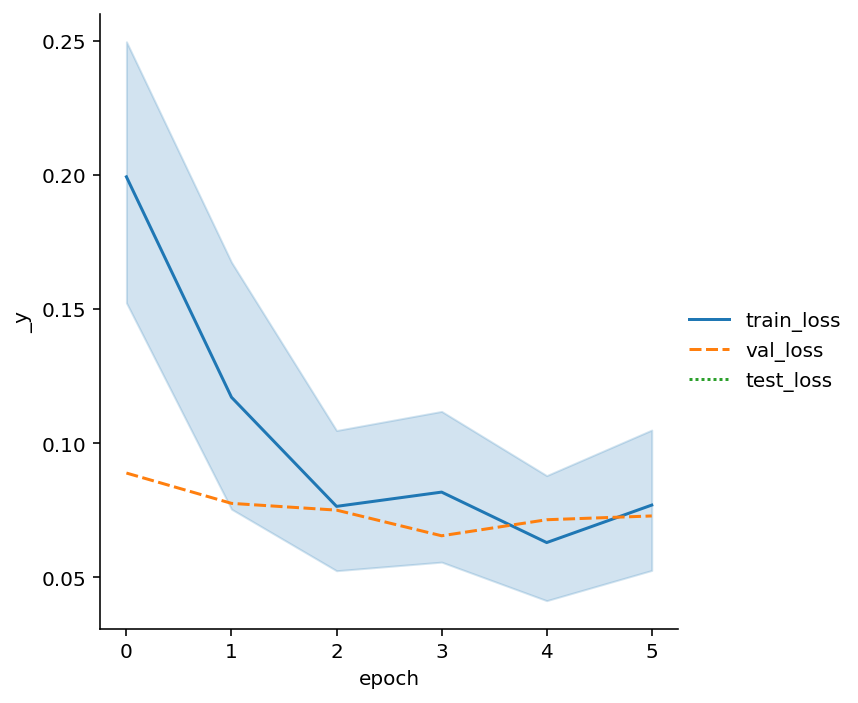

In [39]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sns.relplot(data=metrics, kind="line")

Tune from attack P1

In [40]:
swat_attack.isnull().any()

Timestamp        False
FIT101           False
LIT101           False
MV101            False
P101             False
P102             False
AIT201           False
AIT202           False
AIT203           False
FIT201           False
MV201            False
P201             False
P202             False
P203             False
P204             False
P205             False
P206             False
DPIT301          False
FIT301           False
LIT301           False
MV301            False
MV302            False
MV303            False
MV304            False
P301             False
P302             False
AIT401           False
AIT402           False
FIT401           False
LIT401           False
P401             False
P402             False
P403             False
P404             False
UV401            False
AIT501           False
AIT502           False
AIT503           False
AIT504           False
FIT501           False
FIT502           False
FIT503           False
FIT504           False
P501       

In [46]:
x_attack = swat_attack.drop(columns="Normal/Attack")[["FIT101","LIT101","MV101","P101","P102"]]
y_attack= swat_attack["Normal/Attack"]

In [47]:
x_scale_attack = pd.DataFrame(
    scaler.transform(x_attack),
    index = x_attack.index,
    columns= x_attack.columns
)

In [48]:
y_attack = pd.DataFrame(
    le.transform(y_attack), #normal 1, attack 0
    index = y_attack.index,
    columns= ["label"]
)

In [49]:
x_scale_attack_tune = x_scale_attack[["FIT101","LIT101","MV101","P101","P102"]]

In [50]:
tune_seq = sequences_convert(x_scale_attack_tune,y_attack,sequence_length)

  0%|          | 0/449519 [00:00<?, ?it/s]

In [77]:
len(tune_seq)

449519

In [52]:
tune_dataset = SWaTDataset(tune_seq)

pred = []
labels = []
attacks = []

for item in tqdm(tune_dataset):
  sequences = item["sequences"]
  label = item["label"]
  attack = item["attack"]

  _, output = train_model(sequences.unsqueeze(dim=0))
  # print(output.shape)
  pred.append(output.reshape(sequence_length,n_features).numpy())
  labels.append(label.reshape(sequence_length,n_features).numpy())
  attacks.append(attack.reshape(sequence_length,1).numpy())

pred = np.reshape(pred, (len(tune_seq), n_features))
labels = np.reshape(labels, (len(tune_seq), n_features))
attacks = np.reshape(attacks, (len(tune_seq), 1))

  0%|          | 0/449519 [00:00<?, ?it/s]

In [53]:
print("pred, labels, attacks")
print(len(pred), len(labels),len(attacks))

pred, labels, attacks
89903800 89903800 89903800


In [54]:
pred = pd.DataFrame(pred, columns = x_scale.columns)
labels = pd.DataFrame(labels, columns = x_scale.columns)
attacks = pd.DataFrame(attacks, columns = ["Normal/Attack"])

In [80]:
np.reshape(pred,(len(tune_seq),n_features))

ValueError: ignored

In [55]:
error = abs(labels - pred)
zscores = abs(error - np.mean(error,axis=0))/np.std(error,axis=0)

In [72]:
def pred_anomaly(W: int, T ,zscores: pd.DataFrame):
  
  pred_labels = []
  n_data = len(zscores)

  for i in tqdm (range(n_data-W)):
    z_max = max(np.max(zscores[i:i+W],axis = 1))
    pred_label = 1
    if z_max > T > 0 : #exceed threshold predict-> abnormal
      pred_label = 0
    
    pred_labels.append(pred_label)

  return pred_labels

In [73]:
W = 100
T = [2, 2.5, 3, 3.5]

In [70]:
from sklearn.metrics import f1_score

In [74]:
F1 = []
for i in T:
  result = pred_anomaly(W,i,zscores)
  f1 = f1_score(attacks,result)
  F1.append(f1)

plt.plot(T,F1)

  0%|          | 0/89903700 [00:00<?, ?it/s]

KeyboardInterrupt: ignored